In [1]:
import os
os.chdir("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy


from src.tsa.ts_utils import *
from src.text.epu import *
from src.text.utils import *
from statsmodels.tsa.api import VAR

In [2]:
nlp = spacy.load("en_core_web_sm")
folderpath = os.getcwd() + "/data/text/solomon_islands/"

In [3]:
files_list = [
    folderpath + file for file in os.listdir(folderpath)
    if "news" in file and "ner" not in file
]

In [4]:
abc_path = os.getcwd() + "/data/text/abc_au/"
abc_news = pd.read_csv(abc_path + "solomon_islands_abc_news.csv").drop("Unnamed: 0", axis=1)
abc_url = pd.read_csv(abc_path + "solomon_islands_abc_urls.csv").drop("Unnamed: 0", axis=1)

abc = abc_news.merge(abc_url[["url", "date"]], how="left", on="url")
abc["news"] = abc["news"].replace("\n", "")
abc["date"] = pd.to_datetime(abc["date"])
abc["ym"] = [str(d.year) + "-" + str(d.month) for d in abc.date]

In [5]:
rnz_path = abc_path = os.getcwd() + "/data/text/rnz/"
rnz_news = pd.read_csv(rnz_path+ "solomon_islands_rnz_news.csv").drop("Unnamed: 0", axis=1)
rnz_url = pd.read_csv(abc_path + "solomon_islands_rnz_urls.csv").drop("Unnamed: 0", axis=1)

In [6]:
rnz = rnz_news.merge(rnz_url[["url", "date"]], how="left", on="url")
rnz["news"] = rnz["news"].replace("\n", "").str.lower()
rnz["date"] = pd.to_datetime(rnz["date"])
rnz["ym"] = [str(d.year) + "-" + str(d.month) for d in rnz.date]

In [7]:
ss = process_data(files_list[0])
st = process_data(files_list[1])
tis = process_data(files_list[2])
sibc = process_data(files_list[3])

In [8]:
econ_lst = [
    "economy", "economic", "economics", "business", "commerce", "finance",
    "industry"
]

uncertain_lst = [
    "uncertain", "uncertainty", "uncertainties", "unknown", "unstable",
    "unsure", "undetermined", "risky", "risk", "not certain", "non-reliable"
]

policy_lst = [
    "government", "governmental", "authorities", "minister", "ministry",
    "parliament", "parliamentary", "tax", "regulation", "legislation",
    "central bank", "cbsi", "imf", "world bank", "international monetary fund",
    "debt"
]

solomon_lst = [
    "solomon", "solomon islands", "honiara", "central province", "tulagi",
    "choiseul", "taro", "guadalcanal", "isabel province", "buala", "malaita",
    "auki", "kirakira", "makira-ulawa", "makira ulawa", "rennell and bellona",
    "tigoa", "temotu", "lata", "western province", "gizo"
]
inflation = [
    "inflation", "consumer prices", "rising prices", "living costs","cpi",
    "purchasing power", "interest rates", "wage growth", "commodity prices",
    "supply chain disruptions", "spending", "exchange rates"
]
unemployment = [
    'employment', 'job', 'workforce', 'labor', 'occupation', 'career',
    'hiring', 'unemployment', 'employment rate', 'job market', 'labor force',
    'job creation', 'job loss', 'wage', 'salary', 'income', 'compensation',
    'benefits', 'promotion', 'retirement', 'termination', 'layoff',
    'redundancy', 'resignation', 'job satisfaction', 'labor market',
    'part-time', 'full-time', 'temporary work', 'permanent employment',
    'freelance', 'self-employment', 'underemployment', 'skill set',
    'human capital', 'workplace', 'employment contract', 'labor union',
    'equal opportunity', 'discrimination', 'labor laws', 'labor rights',
    'wage growth', 'income inequality', 'labor shortage', 'job training',
    'job prospects', 'job turnover', 'job search'
]


In [9]:
mindate = min(st.date.min(), ss.date.min(), tis.date.min())
maxdate = max(st.date.max(), st.date.max(),  tis.date.max())
start = str(mindate.year) + "-" + str(mindate.month)
end = str(maxdate.year) + "-" + str(maxdate.month)

In [26]:
# import nltk
# from nltk.corpus import stopwords
# from src.text.utils import *

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# spacy_stopwords = list(nlp.Defaults.stop_words)

# nltk_stopwords = stopwords.words("english")
# nltk_unique = [sw for sw in nltk_stopwords if sw not in spacy_stopwords]
# spacy_stopwords.extend(nltk_unique)

In [10]:
def check_entity_in_terms(row, terms):
    nlp = spacy.load('en_core_web_sm')
    if isinstance(row, str):
        doc = nlp(row)
        tokens = [token for token in doc]
        for token in tokens:
            lowered_token = str(token).lower()
            if lowered_token in terms and token.ent_type != 0:
                return True
            else:
                return False
    else:
        return False

In [11]:
ensemble = [
    "economy", "economic", "economics", "business", "commerce", "finance",
    "industry", "uncertain", "uncertainty", "uncertainties", "unknown", "unstable",
    "unsure", "undetermined", "risky", "risk", "not certain", "non-reliable"
]


stats = pd.DataFrame(pd.date_range(start, end, freq="MS"), columns=["date"])
for npa, np_name in zip([st, ss, tis, sibc, abc, rnz],
                        ["st", "ss", "tis", "sibc", "abc", "rnz"]):
    npa["news"] = npa["news"].str.lower()
    np_count = get_news_count(npa, "news")
    for (category,
         term_lst) in zip(["econ", "uncertain", "policy", "plus"],
                          [econ_lst, uncertain_lst, policy_lst, unemployment]):
        npa[str(category)] = npa["news"].apply(is_in_word_list, terms=term_lst)
    npa["epu"] = ((npa.econ == True) & (npa.uncertain == True)  & 
                   (npa.policy == True) )
#     npa["ec"] = npa["news"].apply(check_entity_in_terms, terms=uncertain_lst)
#     print(f"{np_name} has done")
    np_epu_count = get_news_count(npa[npa.epu == True], column="epu")
    np_stat = np_count.merge(np_epu_count, how="left").fillna(0)
    np_stat["date"] = pd.to_datetime(np_stat["ym"])
    np_stat["ratio"] = np_stat["epu_count"] / np_stat["news_count"]
#     mean, std = np_stat[np_stat.date < "2020-01-01"]["ratio"].mean(), np_stat[
#         np_stat.date < "2020-01-01"]["ratio"].std()
    std = np_stat["ratio"].std()
    np_stat["z_score"] =  np_stat["ratio"] / (std)

    np_stat.columns = [
        str(np_name) + "_" + str(col) if col != "date" and col != "ym" else col
        for col in np_stat.columns
    ]
    stats = (stats.merge(np_stat, how="left",
                         on="date")).drop("ym", axis=1).fillna(0)

select_cols = [col for col in stats.columns if "z_score" in col]
scaling_factor = 100 / (stats[select_cols].mean(
    axis=1).mean())
scaling_factor = 100/(stats[select_cols].mean(axis=1).mean())
stats["z_score"] = stats[select_cols].mean(axis=1)
stats["epu_index"] = stats["z_score"] * scaling_factor

<AxesSubplot:xlabel='date'>

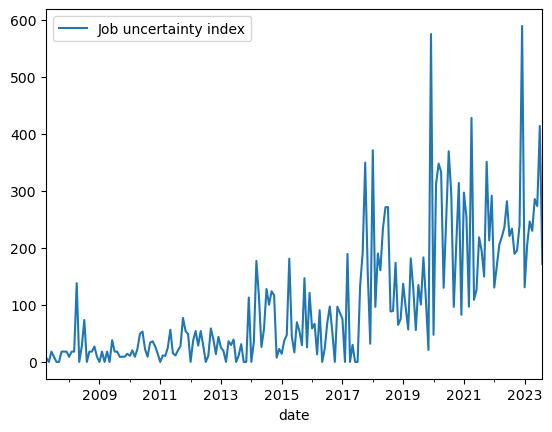

In [12]:
stats.plot(x="date", y="epu_index", label="Job uncertainty index")

## EPU -> Macroeconomic

In [13]:
si_cpi = [
    98.6, 99.0, 100.6, 100.7, 101.0, 100.6, 100.5, 100.1, 99.5, 99.6, 99.5,
    100.3, 102.0, 104.2, 103.9, 103.9, 103.0, 102.8, 103.0, 103.2, 104.0,
    103.8, 104.1, 104.2, 104.5, 103.8, 105.1, 104.2, 104.2, 104.3, 105.0,
    108.0, 105.5, 106.6, 106.9, 106.9, 112.4, 112.7, 112.7, 112.2, 111.1,
    107.2, 105.8, 105.1, 105.4, 105.2, 105.3, 104.1, 106.7, 110.6, 112.4,
    109.8, 109.2, 106.6, 106.1, 106.6, 107.3, 107.5, 107.4, 107.8, 108.8,
    109.4, 109.4, 111.5, 113.9, 114.1, 115.4, 117.1, 118.0, 117.8, 117.2,
    117.0, 118.9, 119.2, 119.8
]

si_infl_df = pd.DataFrame(pd.date_range("2017-01", "2023-03", freq="MS"),
                          columns=["date"])
si_infl_df["cpi"] = si_cpi
si_infl = si_infl_df.merge(stats[["date", "epu_index"]], how="left", on="date")
si_infl["inflation"] = (si_infl["cpi"].diff().shift(-1) / si_infl["cpi"]) * 100
si_infl["epu_change"] = (si_infl["epu_index"].diff() /
                         si_infl["epu_index"].shift(1)) * 100

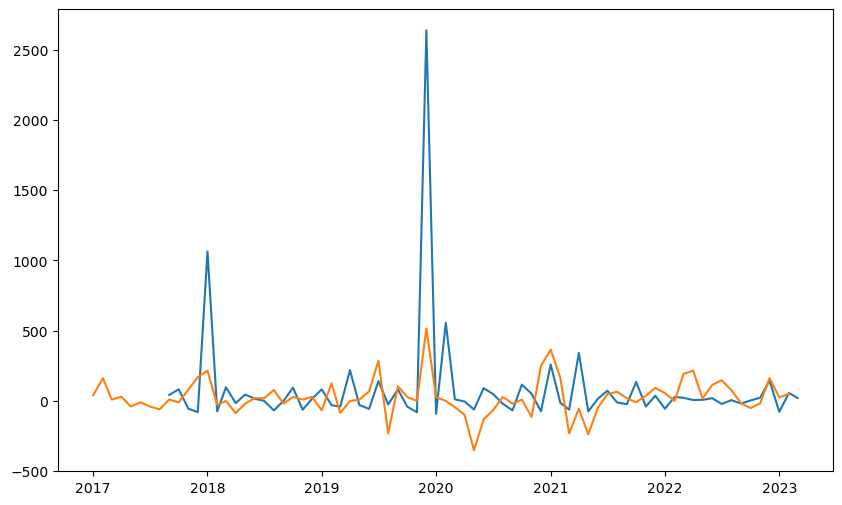

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(si_infl["date"].values, si_infl["epu_change"].values, label="epu_change")
plt.plot(si_infl["date"].values, si_infl["inflation"].values*100, label="inflation");

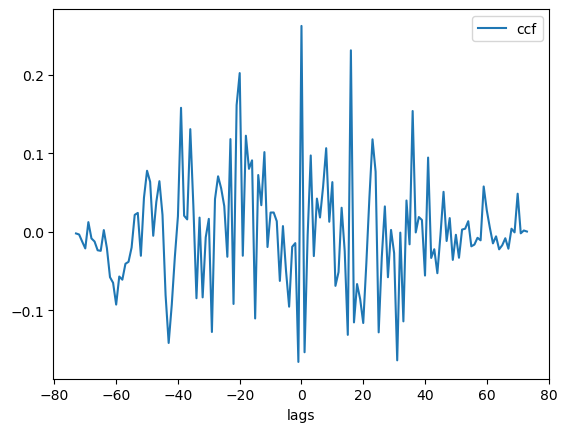

In [15]:
ccf_df = cross_correlation(si_infl["epu_index"][:-1], si_infl["inflation"][:-1])
ccf_df.plot(x="lags");

In [28]:
var_df = si_infl[["inflation", "epu_index"]][:-1].reset_index(drop=True)
print(adf_test(var_df["epu_index"]), "\n", adf_test(var_df["inflation"]))

Test Statistic                 -3.025668
p-value                         0.032566
# Lags Used                     2.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64 
 Test Statistic                -6.971426e+00
p-value                        8.644916e-10
# Lags Used                    0.000000e+00
Number of Observations Used    7.300000e+01
Critical Value (1%)           -3.523284e+00
Critical Value (5%)           -2.902031e+00
Critical Value (10%)          -2.588371e+00
dtype: float64


In [29]:
cointegration_test(var_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
inflation ::  15.83     > 12.3212   =>   True
epu_index ::  0.0       > 4.1296    =>   False


In [30]:
length = len(si_infl.iloc[1:])
train = int(length * 0.9)
test = length - train


model = VAR(endog=var_df[:train+1])

eval_lst = []
for i in range(1, 13):
    result = model.fit(i)
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)
    
eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,1,10.040776,10.239836,22946.056440,10.119434
1,2,10.104573,10.439094,24469.488452,10.236563
2,3,10.091442,10.563698,24178.026435,10.277488
3,4,10.164310,10.776634,26062.306343,10.405140
4,5,10.306398,11.061188,30151.453035,10.602748
5,6,10.430412,11.330129,34326.787104,10.783020
6,7,10.515370,11.562542,37685.148109,10.924977
7,8,10.591893,11.789118,41170.531239,11.059241
8,9,10.752911,12.102857,49170.738337,11.278742
9,10,10.673176,12.178582,46437.910701,11.258228


In [31]:
best_mod = model.fit(1)
best_mod.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Oct, 2023
Time:                     17:08:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.2398
Nobs:                     66.0000    HQIC:                   10.1194
Log likelihood:          -512.645    FPE:                    22946.1
AIC:                      10.0408    Det(Omega_mle):         20994.1
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.714364         0.294590            2.425           0.015
L1.inflation         0.250621         0.124182            2.018           0.044
L1.epu_index        -0.002872         0.001416           -2.

In [32]:
import statsmodels.formula.api as smf
ols_mod = smf.ols("inflation~epu_index", data=var_df)
ols_res = ols_mod.fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     5.480
Date:                Tue, 10 Oct 2023   Prob (F-statistic):             0.0220
Time:                        17:08:47   Log-Likelihood:                -120.48
No. Observations:                  74   AIC:                             245.0
Df Residuals:                      72   BIC:                             249.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2549      0.268     -0.952      0.344      -0.789       0.279
epu_index      0.0028      0.001      2.341      0.022       0.000       0.005
==============================================================================
Omnibus:                        5.498   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                6.707
Skew:                           0.253   Prob(JB):                       0.0350
Kurtosis:                       4.385   Cond. No.                         409.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
ols_predict = ols_res.fittedvalues
# ols_forecast = ols_res.predict(si_infl["epu_change_1"])
# ols_all = pd.concat([ols_predict, ols_forecast], axis=0)

In [34]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(best_mod.resid)
out

array([1.94594581, 2.00432178])

In [35]:
var_forecast = best_mod.forecast(y=var_df.values[-test:], steps=test)
var_forecast_df = pd.DataFrame(var_forecast, index=var_df.index[-test:], columns=["var_inflation", "var_epu"])

In [37]:
var_df["date"] = pd.date_range(start="2017-01", periods=len(var_df), freq="MS")
fit_df = best_mod.fittedvalues.rename({"epu_index": "var_epu_index",
                                       "inflation": "var_inflation"}, axis=1)
fit_df = pd.concat([fit_df, var_df[1:train+1]], axis=1).reset_index(drop=True)

In [38]:
var_df["date"] = pd.date_range(start="2017-01", periods=len(var_df), freq="MS")
var_df

,inflation,epu_index,date
0,0.405680,75.298549,2017-01-01
1,1.616162,0.000000,2017-02-01
2,0.099404,189.465159,2017-03-01
3,0.297915,0.000000,2017-04-01
4,-0.396040,29.993815,2017-05-01
...,...,...,...
69,-0.509338,195.424852,2022-10-01
70,-0.170648,240.022712,2022-11-01
71,1.623932,589.339801,2022-12-01
72,0.252313,130.847303,2023-01-01


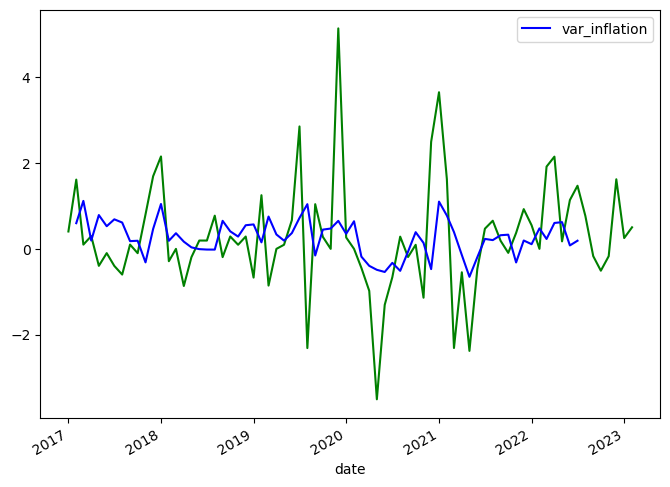

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(var_df["date"].values, var_df["inflation"].values, color="green")
fit_df.plot(x="date", y="var_inflation", ax=ax, color="blue")
# ax.plot(var_df["date"][1:].values, ols_all.values)
# ax.plot(var_forecast_df["var_inflation"].index.values,
#         var_forecast_df["var_inflation"].values,
#         label="var_predict_test", color="blue")
# ax.plot(ols_all, color="orange")
plt.show();